In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import cftime


KeyboardInterrupt: 

In [ ]:
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
from Streamfunctions import *

### Request HPC Resources

In [ ]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='03:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

### Load in data

In [ ]:
import cmocean
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'}, #originally mol/m^3
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [ ]:
import glob
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/" + x
datafiles = glob.glob(datadir("CM4Xp125*")) #[20:]
datafiles = sorted(datafiles)

In [103]:
def volume_weighted_average(ds):
    thicknesses = ds.thkcello.fillna(0.0)
    thicknesses = thicknesses.where(thicknesses > 0)
    weights = (thicknesses * ds.areacello)
    weighted_ds = (ds.drop_vars(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

In [104]:
ds_psis = []
for (t, file) in enumerate(datafiles): 
    if (t % 5) == 0: 
        print(file)
    ds = xr.open_mfdataset(
        file,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    
    psi_year = compute_streamfunction(ds, 
                           z_coord = "sigma2_l", 
                           reverse_cumsum = True).compute()

    ds_psis += [1 * psi_year]

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1750-1754.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1775-1779.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1800-1804.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1825-1829.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1850-1854.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1875-1879.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_1900-1904.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2

In [105]:
def update_year(dates, new_year):
    # Vectorized approach: create new DatetimeNoLeap objects with the updated year
    new_dates = []
    for (i, d) in enumerate(dates):
        model_year = d.dt.year
        new_dates += [cftime.DatetimeNoLeap(new_year + ((model_year - 1)%5), d.dt.month, d.dt.day)]
    return np.array(new_dates)


In [106]:
ds_psis_modified = 1 * ds_psis
for (i, d) in enumerate(ds_psis_modified):
    if i <= 19:
        ds_psis_modified[i]["time_since_init"] = ds_psis_modified[i]["time"].copy()
        ds_psis_modified[i].coords["time"] = update_year(ds_psis_modified[i]["time"], 1750  + (i * 5))

In [107]:
ds_psi_ts = 1e-6 * xr.concat(ds_psis_modified, dim = "time").sortby("time")
ds_psi_ts.attrs["units"] = "Sverdrups"
ds_psi_ts.attrs["long_name"] = "Isopycnal Overturning Streamfunction"
ds_psi_ts.attrs["orientation"] = "Positive values indicate clockwise circulation. Negative counterclockwise."

savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"

savename = savedir + f"CM4xp125_isopycnal_streamfunction_since_init.nc"
ds_psi_ts.to_netcdf(savename)

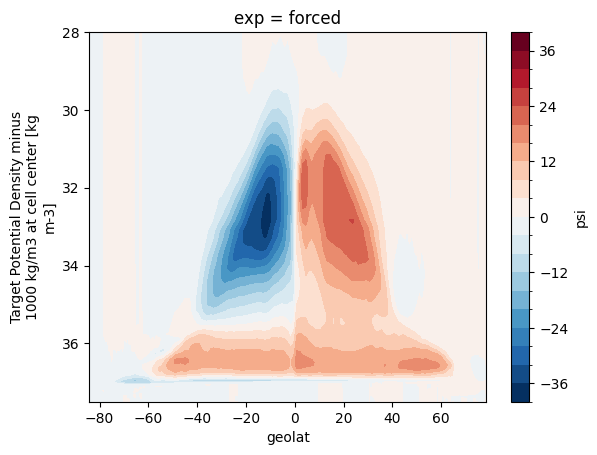

In [108]:
fig, ax = plt.subplots(sharey = True)
ds_psi_ts.mean("time").isel(exp = 0).plot.contourf(x = "geolat", y = "sigma2_l", ax = ax, levels = 25)

ax.set_ylim(28, 37.5)
ax.invert_yaxis()

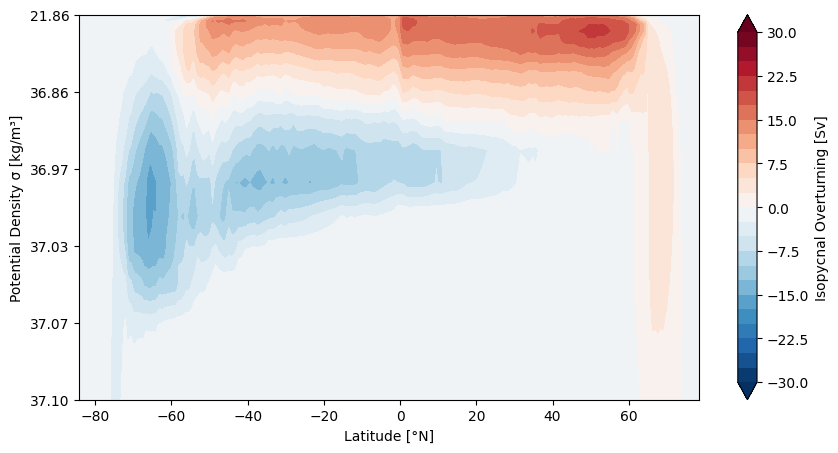

In [109]:
psi_crop = ds_psi_ts.mean("time").sel(sigma2_l = slice(20, 37.1))
psi_crop = psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.arange(-30, 30.1, 2.5)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1),
    streamfunction_var='psi',  # Your streamfunction variable name
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='geolat',                  # Your latitude dimension name
    power = 100,
    levels = levels
)

ax.invert_yaxis()

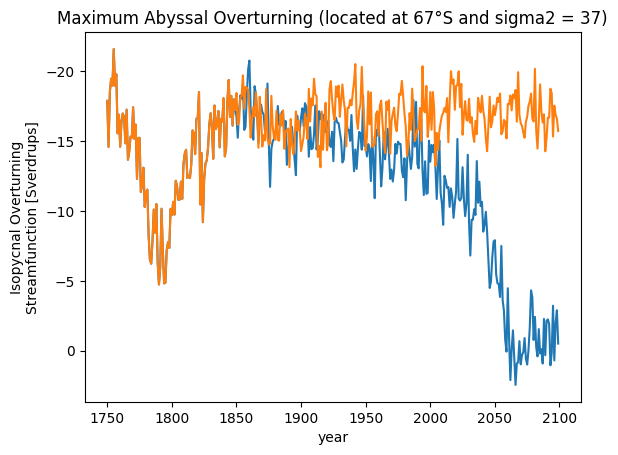

In [111]:
ds_psi_yearly = ds_psi_ts.groupby("time.year").mean("time")
ds_psi_yearly = ds_psi_yearly.sel(sigma2_l = slice(36, 37.1))

locs = find_min_locations(ds_psi_yearly.isel(exp = 1).mean("year"))

fig, ax = plt.subplots()
(ds_psi_yearly).isel(exp = 0).sel(locs).plot(ax = ax)
(ds_psi_yearly).isel(exp = 1).sel(locs).plot(ax = ax)

ax.set_title("Maximum Abyssal Overturning (located at 67°S and sigma2 = 37)")

ax.invert_yaxis()